In [186]:
import pandas as pd
import numpy as np
import fasttext
from sklearn.impute import SimpleImputer
import re
import langid # need to be installed
import fasttext # need to be installed
import os
from SVM import SVMClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [187]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [188]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 585 entries, 0 to 584
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            585 non-null    int64  
 1   Species               585 non-null    object 
 2   Farm.Name             419 non-null    object 
 3   Lot.Number            105 non-null    object 
 4   Altitude              518 non-null    object 
 5   Number.of.Bags        585 non-null    int64  
 6   Bag.Weight            585 non-null    object 
 7   Harvest.Year          575 non-null    object 
 8   Grading.Date          585 non-null    object 
 9   Variety               524 non-null    object 
 10  Processing.Method     533 non-null    object 
 11  Aroma                 585 non-null    float64
 12  Flavor                585 non-null    float64
 13  Aftertaste            585 non-null    float64
 14  Acidity               585 non-null    float64
 15  Body                  5

In [189]:
train_data.isnull().sum()

Unnamed: 0                0
Species                   0
Farm.Name               166
Lot.Number              480
Altitude                 67
Number.of.Bags            0
Bag.Weight                0
Harvest.Year             10
Grading.Date              0
Variety                  61
Processing.Method        52
Aroma                     0
Flavor                    0
Aftertaste                0
Acidity                   0
Body                      0
Balance                   0
Uniformity                0
Clean.Cup                 0
Sweetness                 0
Cupper.Points             0
Total.Cup.Points          0
Moisture                  0
Category.One.Defects      0
Quakers                   1
Color                   116
Category.Two.Defects      0
Expiration                0
Country.of.Origin         0
dtype: int64

Class Distribution:


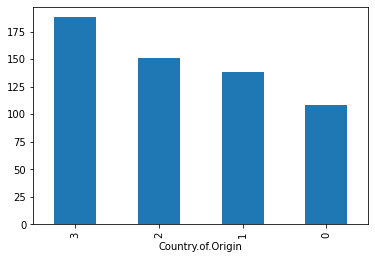

In [190]:
print("Class Distribution:")
train_data['Country.of.Origin'].value_counts().plot(kind='bar')
plt.show()

In [191]:
class Preprocessor:
   def __init__(self):
       self.nlp_model = fasttext.load_model('lid.176.bin')
       self.categories = ['Bourbon', 'Caturra', 'Typica']

   def farm_name_preprocess(self, x):
       if pd.isnull(x):
           return 'other'
       else:
           try:
               fasttext_lang = self.nlp_model.predict(x, k=10)
               fasttext_lang_probs = {lang.split("__")[-1]: prob for lang, prob in zip(fasttext_lang[0], fasttext_lang[1])}
               if langid.classify(x)[0] == 'en':
                   if x in ['several', 'various', 'unkown']:
                       return 'other'
                   else:
                       return 'en'
               es_prob = fasttext_lang_probs.get('es', 0)
               pt_prob = fasttext_lang_probs.get('pt', 0)
               if pt_prob > es_prob:
                   return 'pt'
               else:
                   return 'es'
           except:
               return 'other'

   def altitude_preprocess(self, x):
       if pd.isnull(x):
           return x
       elif x.isdigit():
           return int(x)
       else:
           numbers = re.findall(r'\d+(?:\.\d+)?', x)
           numbers = [float(num.replace('.', '')) for num in numbers]
           if len(numbers) >= 2:
               return np.mean(numbers)
           elif len(numbers) == 1:
               return numbers[0]
           else:
               return np.nan

   def bag_weight_preprocess(self, x):
       if x.isdigit():
           weight = float(x)
       else:
           num, unit = x.split()
           if unit == 'lbs':
               weight = float(num) * 0.453592
           else:
               weight = float(num)
       if weight >= 59:
           return 'big'
       else:
           return 'small'

   def grading_date_preprocess(self, x):
       return int(x.split(', ')[1])

   def variety_preprocess(self, x):
       if x not in self.categories:
           return 'Other'
       else:
           return x

   def preprocess(self, df):
       df = df.iloc[:, 1:].drop(['Species', 'Lot.Number', 'Expiration', 'Harvest.Year'], axis=1)

       df['Language'] = df['Farm.Name'].apply(self.farm_name_preprocess)
       df['Altitude'] = df['Altitude'].apply(self.altitude_preprocess)
       df['Bag.Weight'] = df['Bag.Weight'].apply(self.bag_weight_preprocess)
       df['Grading.Year'] = df['Grading.Date'].apply(self.grading_date_preprocess)
       df['Variety'] = df['Variety'].apply(self.variety_preprocess)
       df['Processing.Method'] = df['Processing.Method'].fillna('Other')
       df['Color'] = df['Color'].fillna('Other')

       df.drop(['Farm.Name', 'Grading.Date'], axis=1, inplace=True)
       df.dropna(subset=['Quakers'], inplace=True)

       object_cols = list(df.select_dtypes(include='object').columns)
       df = pd.get_dummies(df, columns=object_cols, drop_first=True)

       imputer = SimpleImputer()
       df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

       df['Altitude'] = np.log(df['Altitude'])

       return df

In [192]:
preprocessor = Preprocessor()
train_data = preprocessor.preprocess(train_data)
test_data = preprocessor.preprocess(test_data)

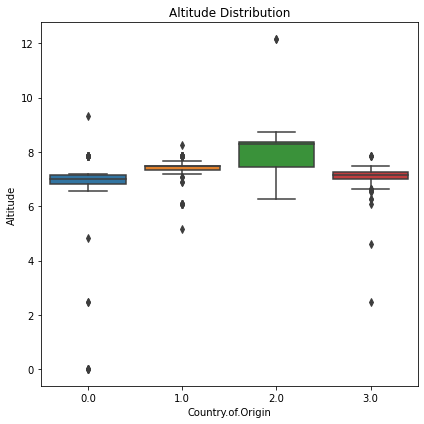

In [193]:
plt.figure(figsize=(6, 6))
sns.boxplot(x='Country.of.Origin', y='Altitude', data=train_data)
plt.title('Altitude Distribution')
plt.tight_layout()
plt.show()

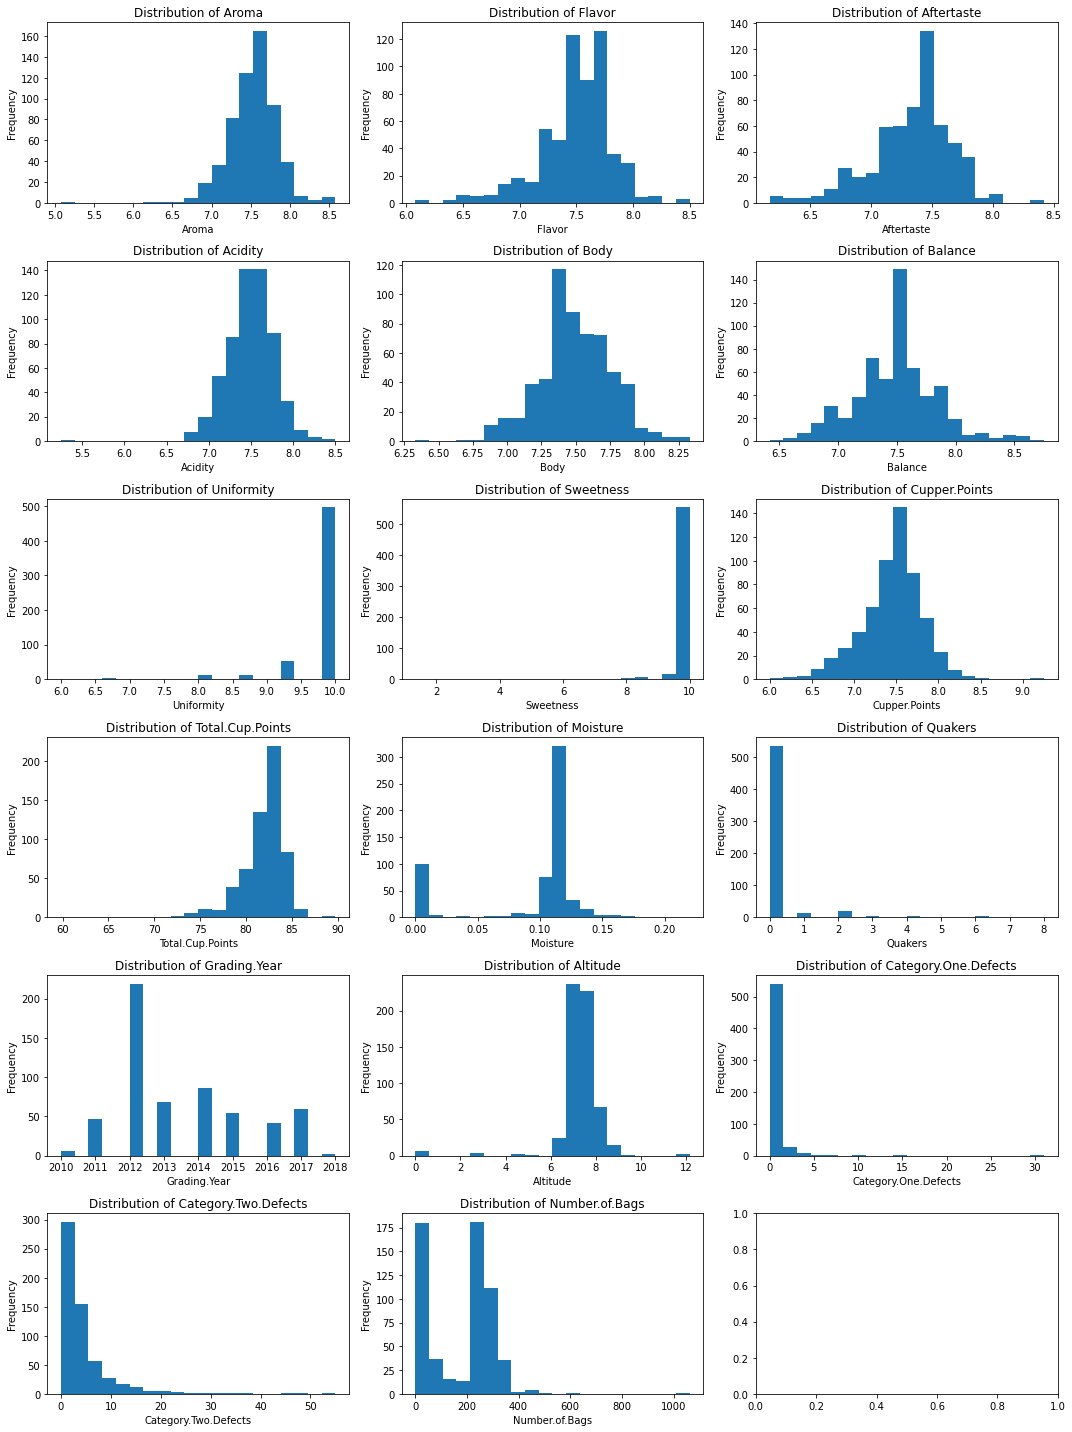

In [194]:
# Visualize Distributions

target_cols = ['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 'Uniformity', 'Sweetness', 'Cupper.Points', 'Total.Cup.Points', 
               'Moisture', 'Quakers', 'Grading.Year', 'Altitude',
               'Category.One.Defects','Category.Two.Defects', 'Number.of.Bags']

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 20))
axes = axes.flatten()

for i, col in enumerate(target_cols):
    if train_data[col].dtype == 'float64' or train_data[col].dtype == 'int64':
        axes[i].hist(train_data[col], bins=20)
    else:
        train_data[col].value_counts().plot(kind='bar', ax=axes[i])
    
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [195]:
class Trainer():
    def __init__(self, targets):
        self.targets = targets

    def fit(self, X_train, y_train):
        self.X_train, self.y_train = X_train, y_train
        
        self.clfs = []
        for target in self.targets:
            bin_y = np.where(self.y_train.values==target, 1, 0)
            svc = SVMClassifier()
            svc.fit(self.X_train, bin_y)
            self.clfs.append(svc)

    def predict(self, X_test):
        self.X_test = X_test

        results = []
        
        for i in range(len(self.targets)):
            results.append(self.clfs[i].predict(self.X_test))
        
        results = np.array(results)
        return np.argmax(results, axis=0)


    def get_accuracy_score(self, y_true, y_pred):
        return f'{np.sum(y_true == y_pred) / len(y_pred):.4f}'

In [196]:
# Test Data Prediction

train_X = train_data[[col for col in train_data.columns if col not in ['Country.of.Origin']]]
train_y = train_data['Country.of.Origin']

scaler = RobustScaler()
train_X = scaler.fit_transform(train_X)
test_data = scaler.fit_transform(test_data)

trainer = Trainer(targets=np.unique(train_y))
trainer.fit(train_X, train_y)

results = pd.DataFrame({'Country.of.Origin': trainer.predict(test_data)}, index=pd.Index(range(len(test_data)), name='id'))

results.to_csv('submission.csv')

Accuracy:  0.906

Confusion Matrix


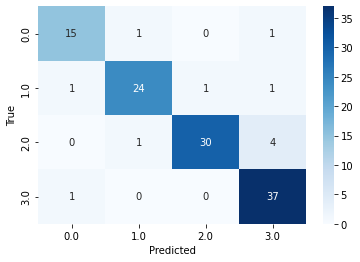


Classification Report
              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88        17
         1.0       0.92      0.89      0.91        27
         2.0       0.97      0.86      0.91        35
         3.0       0.86      0.97      0.91        38

    accuracy                           0.91       117
   macro avg       0.91      0.90      0.90       117
weighted avg       0.91      0.91      0.91       117



In [197]:
# Performance Metrics (1)

X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.2, random_state=42)

trainer = Trainer(targets=np.unique(train_y))
trainer.fit(X_train, y_train)
y_pred = trainer.predict(X_val)
accuracy = float(trainer.get_accuracy_score(y_val, y_pred))


print('Accuracy: ', accuracy)

print('\nConfusion Matrix')
cm = confusion_matrix(y_val, y_pred)
labels = np.unique(y_val)
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print('\nClassification Report')
print(classification_report(y_val, y_pred))

In [198]:
# Performance Metrics (2)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
for train_index, val_index in kf.split(train_X):
    X_train, X_val = train_X[train_index], train_X[val_index]
    y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
    
    trainer = Trainer(targets=np.unique(train_y))
    trainer.fit(X_train, y_train)
    
    y_pred = trainer.predict(X_val)

    accuracy = float(trainer.get_accuracy_score(y_val, y_pred))
    accuracies.append(accuracy)

# 교차 검증 결과 출력
print(f"K-Fold Cross Validation Accuracies: {accuracies}")
print(f"Mean Accuracy: {np.mean(accuracies):.4f}")

K-Fold Cross Validation Accuracies: [0.906, 0.8889, 0.8803, 0.906, 0.9052]
Mean Accuracy: 0.8973
